In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from fastai.tabular import *
from fastai.callbacks import SaveModelCallback
from fastai.basic_data import DataBunch

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Define some constants

In [4]:
TYPES              = np.array(['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN'])
TYPES_MAP          = {t: i for i, t in enumerate(TYPES)}
SC_EDGE_FEATS      = ['type_0', 'type_1', 'type_2', 'type_3', 'type_4', 'type_5', 'type_6', 'type_7', 
                      'dist', 'dist_min_rad', 'dist_electro_neg_adj', 'normed_dist', 
                      'diangle', 'cos_angle', 'cos_angle0', 'cos_angle1', 
                      #'inv_dist', 'normed_inv_dist'
                     ]
SC_MOL_FEATS       = ['type_0', 'type_1', 'type_2', 'type_3', 'type_4', 'type_5', 'type_6', 'type_7', 
                      'dist', 'dist_min_rad', 'dist_electro_neg_adj', 'normed_dist', 
                      'diangle', 'cos_angle', 'cos_angle0', 'cos_angle1', 
                      'num_atoms', 'num_C_atoms', 'num_F_atoms', 'num_H_atoms', 'num_N_atoms', 'num_O_atoms', 
                      #'inv_dist', 'normed_inv_dist', 
                      'std_bond_length', 'ave_bond_length', #'total_bond_length',  
                      #'ave_inv_bond_length', 'total_inv_bond_length', 
                      'ave_atom_weight', #'total_atom_weight'
                     ]
ATOM_FEATS         = ['type_H', 'type_C', 'type_N', 'type_O', 'type_F', 
                      'degree_1', 'degree_2', 'degree_3', 'degree_4', 'degree_5', 
                      'SP', 'SP2', 'SP3', 'hybridization_unspecified', 
                      'aromatic', 'formal_charge', 'atomic_num',
                      'donor', 'acceptor', 
                      'ave_bond_length', 
                      #'ave_inv_bond_length',
                      'ave_neighbor_weight']
EDGE_FEATS         = ['single', 'double', 'triple', 'aromatic', 
                      'conjugated', 'in_ring',
                      'dist', 'normed_dist', 
                      #'inv_dist', 'normed_inv_dist'
                     ]
CONTRIB_COLS       = ['fc', 'sd', 'pso', 'dso']
N_EDGE_FEATURES    = len(EDGE_FEATS)
N_SC_EDGE_FEATURES = len(SC_EDGE_FEATS)
N_SC_MOL_FEATURES  = len(SC_MOL_FEATS)
N_ATOM_FEATURES    = len(ATOM_FEATS)
N_TYPES            = len(TYPES)
N_MOLS             = 130775
SC_MEAN            = 16
SC_STD             = 35

In [5]:
SC_FEATS_TO_SCALE   = ['dist', 'dist_min_rad', 'dist_electro_neg_adj', 'num_atoms', 'num_C_atoms', 
                       'num_F_atoms', 'num_H_atoms', 'num_N_atoms', 'num_O_atoms', 'inv_dist', 
                       'ave_bond_length', 'std_bond_length', 'total_bond_length',  'ave_inv_bond_length', 
                       'total_inv_bond_length', 'ave_atom_weight', 'total_atom_weight']
ATOM_FEATS_TO_SCALE = ['atomic_num', 'ave_bond_length', 'ave_inv_bond_length', 'ave_neighbor_weight']
EDGE_FEATS_TO_SCALE = ['dist', 'inv_dist']

## Import data

In [6]:
DATA_PATH = '../data/'
PATH = '../tmp/'
# DATA_PATH = '../input/champs-scalar-coupling/'
# PATH = '../input/champs-processed-data-2/'

In [7]:
files = os.listdir(PATH)
files = [f for f in files if f.find('.csv') != -1]
files

['atomic_features.csv',
 'train_proc_df.csv',
 'mask.csv',
 'edge_mask.csv',
 'atom_df.csv',
 'pairs_idx.csv',
 'edge_df.csv',
 'train_idxs_4_fold_cv.csv',
 'edge_features.csv',
 'val_idxs_4_fold_cv.csv',
 'test_proc_df.csv']

In [8]:
files = os.listdir(DATA_PATH)
files = [f for f in files if f.find('.csv') != -1]
files

['scalar_coupling_contributions.csv',
 'mulliken_charges.csv',
 'structures.csv',
 'test.csv',
 'train.csv',
 'magnetic_shielding_tensors.csv',
 'dipole_moments.csv',
 'sample_submission.csv',
 'potential_energy.csv']

In [9]:
train_df = pd.read_csv(PATH+'train_proc_df.csv', index_col=0)
test_df  = pd.read_csv(PATH+'test_proc_df.csv', index_col=0)
atom_df  = pd.read_csv(PATH+'atom_df.csv', index_col=0)
edge_df  = pd.read_csv(PATH+'edge_df.csv', index_col=0)
contribs_df = pd.read_csv(DATA_PATH+'scalar_coupling_contributions.csv')

/anaconda2/envs/python36/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [10]:
contribs_df['molecule_id'] = train_df['molecule_id']

In [11]:
train_df['scalar_coupling_constant'] = (train_df['scalar_coupling_constant'] - SC_MEAN) / SC_STD
contribs_df['fc'] = contribs_df['fc'] - SC_MEAN
contribs_df[CONTRIB_COLS] = contribs_df[CONTRIB_COLS] / SC_STD

In [12]:
train_df['num_atoms'] = train_df[['num_C_atoms', 'num_F_atoms', 'num_H_atoms', 
                                  'num_N_atoms', 'num_O_atoms']].sum(axis=1)
test_df['num_atoms'] = test_df[['num_C_atoms', 'num_F_atoms', 'num_H_atoms', 
                                'num_N_atoms', 'num_O_atoms']].sum(axis=1)
train_df[['num_atoms', 'num_C_atoms', 'num_F_atoms', 'num_H_atoms', 'num_N_atoms', 'num_O_atoms']] /= 10
test_df[['num_atoms', 'num_C_atoms', 'num_F_atoms', 'num_H_atoms', 'num_N_atoms', 'num_O_atoms']] /= 10

## Define MPNN

General dense feedforward NN

In [13]:
def bn_init(m): pass
#     if type(m) == nn.BatchNorm1d: 
#         nn.init.ones_(m.weight)
#         nn.init.zeros_(m.bias)

def selu_weights_init(m):
    if type(m) == nn.Linear:
        fan_in = m.weight.size(1)
        m.weight.data.normal_(0.0, 1.0 / math.sqrt(fan_in))
        m.bias.fill_(0.0)
    bn_init(m)

def relu_weights_init(m): 
#     if type(m) == nn.Linear:
#         nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
#         m.bias.data.fill_(0.0)
    bn_init(m)

def hidden_layer(n_in, n_out, batch_norm, dropout, layer_norm=False, act=None):
    layers = []
    layers.append(nn.Linear(n_in, n_out))
    if act: layers.append(act)
    if batch_norm: layers.append(nn.BatchNorm1d(n_out))
    if layer_norm: layers.append(nn.LayerNorm(n_out))
    if dropout != 0: layers.append(nn.Dropout(dropout))
    return layers

class FullyConnectedNet(nn.Module):
    
    def __init__(self, n_input, n_output=None, layers=[], act=nn.ReLU(True), dropout=[], batch_norm=False, 
                 out_act=None, final_bn=False, layer_norm=False):
        super().__init__()
        sizes = [n_input] + layers
        if n_output: 
            sizes += [n_output]
            dropout += [0.0]
        layers_ = []
        for i, (n_in, n_out, dr) in enumerate(zip(sizes[:-1], sizes[1:], dropout)):
            act_ = act if i < len(layers) else out_act
            batch_norm_ = batch_norm if i < len(layers) else final_bn
            layer_norm_ = layer_norm if i < len(layers) else False
            layers_ += hidden_layer(n_in, n_out, batch_norm_, dr, layer_norm_, act_)      
        self.layers = nn.Sequential(*layers_)
        if type(act) == nn.SELU: self.layers.apply(selu_weights_init)
        else: self.layers.apply(relu_weights_init)
        
    def forward(self, x):
        return self.layers(x)

The LSTM cell as describedi in the set2set paper (https://arxiv.org/pdf/1511.06391.pdf). Doesn't take any inputs.

In [14]:
class HiddenLSTMCell(nn.Module):
    """Implements the LSTM cell update described in the sec 4.2 of https://arxiv.org/pdf/1511.06391.pdf."""
    
    def __init__(self, n_h_out):
        """This LSTM cell takes no external 'x' inputs, but has a hidden state appended with the 
        readout from a content based attention mechanism. Therefore the hidden state is of a dimension
        that is two times the number of nodes in the set."""
        super().__init__()
        self.n_h_out, self.n_h = n_h_out, n_h_out * 2 
        self.w_h = nn.Parameter(torch.Tensor(self.n_h, n_h_out * 4))
        self.b = nn.Parameter(torch.Tensor(n_h_out * 4))
        self.init_weights()
    
    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
                # nn.init.orthogonal_(p.data)
            else: 
                nn.init.zeros_(p.data)
                # initialize the forget gate bias to 1
                p.data[self.n_h_out:self.n_h_out*2] = torch.ones(self.n_h_out)
        
    def forward(self, h_prev, c_prev):
        """Takes previuos hidden and cell states as arguments and performs a 
        single LSTM step using no external input.
        """
        n_h_ = self.n_h_out # number of output hidden states
        # batch the computations into a single matrix multiplication
        gates = h_prev @ self.w_h + self.b
        i_g, f_g, g, o_g = (
            torch.sigmoid(gates[:, :n_h_]), # input
            torch.sigmoid(gates[:, n_h_:n_h_*2]), # forget
            torch.tanh(gates[:, n_h_*2:n_h_*3]),
            torch.sigmoid(gates[:, n_h_*3:]), # output
        )
        c = f_g * c_prev + i_g * g
        h = o_g * torch.tanh(c)
        return h, c

Set2set module.

In [15]:
def scatter_add(src, idx, num):
    sz = num, src.size(1)
    exp_idx = idx[:,None].repeat(1, sz[1])
    out = torch.zeros(sz, dtype=src.dtype, device=src.device)
    return out.scatter_add(0, exp_idx, src)

def softmax(x, idx, num=None):
    x = x.exp()
    x = x / (scatter_add(x, idx, num=num)[idx] + 1e-16)
    return x

class Set2SetGRU(nn.Module):
    """
    Adapted from: https://rusty1s.github.io/pytorch_geometric/build/html/_modules/torch_geometric\
        /nn/glob/set2set.html#Set2Set
    """
    def __init__(self, n_set_in, proc_steps):
        super().__init__()
        self.proc_steps = proc_steps
        self.gru = nn.GRUCell(n_set_in, n_set_in)
        self.init_q = nn.Parameter(torch.Tensor(1, n_set_in))
        self.init_r = nn.Parameter(torch.Tensor(1, n_set_in))
        nn.init.zeros_(self.init_q)
        nn.init.zeros_(self.init_r)

    def forward(self, x, node_idx):
        """
        x - input tensor of shape (batch_size * n_nodes, in_channels).
        - node_idx: tensor of shape (batch_size * n_nodes) mapping each
            node to its corresponding index in the batch.
        """
        batch_size = node_idx.max().item() + 1
        q = self.init_q.expand(batch_size, -1).contiguous()
        r = self.init_r.expand(batch_size, -1).contiguous()
        for i in range(self.proc_steps):
            q = self.gru(r, q)
            e = (x * q[node_idx]).sum(dim=-1, keepdim=True)
            a = softmax(e, node_idx, num=batch_size)
            r = scatter_add(a * x, node_idx, num=batch_size) # sum 'a*x' over nodes 
        return torch.cat([q, r], dim=-1) #q_star

class Set2SetLSTM(nn.Module):
    """
    Adapted from: https://rusty1s.github.io/pytorch_geometric/build/html/_modules/torch_geometric\
        /nn/glob/set2set.html#Set2Set
    """
    def __init__(self, n_set_in, proc_steps):
        super().__init__()
        self.n_set_in, n_set_out = n_set_in, 2 * n_set_in
        self.proc_steps = proc_steps
        self.lstm = HiddenLSTMCell(n_set_in)
        self.init_q_star = nn.Parameter(torch.Tensor(1, n_set_out))
        self.init_h = nn.Parameter(torch.Tensor(1, n_set_in))
        nn.init.zeros_(self.init_q_star)
        nn.init.zeros_(self.init_h)

    def forward(self, x, node_idx):
        """
        x - input tensor of shape (batch_size * n_nodes, in_channels).
        - node_idx: tensor of shape (batch_size * n_nodes) mapping each
            node to its corresponding index in the batch.
        """
        batch_size = node_idx.max().item() + 1
        h = self.init_h.expand(batch_size, -1).contiguous()
        q_star = self.init_q_star.expand(batch_size, -1).contiguous()
        for i in range(self.proc_steps):
            q, h = self.lstm(q_star, h)
            e = (x * q[node_idx]).sum(dim=-1, keepdim=True)
            a = softmax(e, node_idx, num=batch_size)
            r = scatter_add(a * x, node_idx, num=batch_size) # sum 'a*x' over nodes 
            q_star = torch.cat([q, r], dim=-1)
            
        return q_star

Edge network message function as described in the MPNN paper (https://arxiv.org/pdf/1704.01212.pdf). Adds in seperate edge network to allow messages to flow along scalar coupling edges.

In [16]:
class EdgeNetwork(nn.Module):
    def __init__(self, n_h, n_e, n_sc_e, net_args={}):
        super().__init__()
        self.n_h = n_h
        self.adj_net = FullyConnectedNet(n_e, n_h**2, **net_args)
        self.sc_adj_net = FullyConnectedNet(n_sc_e, n_h**2, **net_args)
        self.b = nn.Parameter(torch.Tensor(n_h)) # bias for the message function
        nn.init.zeros_(self.b)
    
    def forward(self, h, e, sc_e, pairs_idx, sc_pairs_idx, t=0):
        """
        Compute message vector m_t given the previuos hidden state
        h_t-1 and edge features e.
        - h: tensor of hidden states of shape (batch_size * n_nodes, n_h)
        - e: tensor of edge features of shape (batch_size * n_edges, n_e).
        - sc_e: tensor of scalar coupling edge features of shape 
            (batch_size * n_sc, n_sc_e).
        - pairs_idx: tensor of shape (batch_size * n_edges, 2) mapping atom 
            indexes (first column) to the other atom indexes they form a 
            bond with (second column). Atom indices are unique to the entire
            batch.
        - sc_pairs_idx: tensor of shape (batch_size * n_sc, 2) containing atom 
            indices of the atoms for which the scalar coupling constant
            need to be predicted. Atom indices are unique to the entire
            batch.
        - t: update iteration. 
        """
        # compute 'A(e)'
        if t==0: 
            self.a_mat = self.get_a_mat(self.adj_net(e))
            self.a_sc_mat = self.get_a_mat(self.sc_adj_net(sc_e))
            
        # compute 'm_{i} = sum_{j in N(i)}(A_{ij}h_{j})' for all nodes 'i'
        m = self.add_message(torch.zeros_like(h), self.a_mat, h, pairs_idx)
        m = self.add_message(m, self.a_sc_mat, h, sc_pairs_idx)
        return m + self.b # add message bias
    
    def get_a_mat(self, a_vect):
        return a_vect.view(-1, self.n_h, self.n_h) / (self.n_h ** .5)
    
    def add_message(self, m, a, h, pairs_idx):
        # transform 'pairs_idx' and 'a' to make messages go both in to and out of all nodes
        in_out_idx = torch.cat((pairs_idx, pairs_idx[:, [1, 0]]))
        a_ = torch.cat((a, a)) 
        
        # select the 'h_{j}' feeding into the 'm_{i}'
        h_in = h.index_select(0, in_out_idx[:,1])
        
        # do the matrix multiplication 'A_{ij}h_{j}'
        ah = (h_in.unsqueeze(1) @ a_).squeeze(1)
        
        # Sum up all 'A_{ij}h_{j}' per node 'i'
        return m.scatter_add(0, in_out_idx[:,0,None].repeat(1, self.n_h), ah)

The GRU update function as described in the MPNN paper.

In [17]:
class GRUUpdate(nn.Module):
    def __init__(self, n_h):
        super().__init__()
        self.gru = nn.GRUCell(n_h, n_h)
        
    def forward(self, m, h_prev):
        """
        Update hidden state h.
        - h_prev is vector of hidden states of shape (batch_size * n_nodes, n_h)
        - m is vector of messages of shape (batch_size * n_nodes, n_h)
        """
        return self.gru(m, h_prev)

Custom readout network following th set2set processing stage. Allows some final specialization/fine-tuning for each scalar coupling type.

In [18]:
def create_contribs_head(n_in, n_h, act, dropout=0.0, layer_norm=True):
    layers = hidden_layer(n_in, n_h, False, dropout, layer_norm, act)
    layers += hidden_layer(n_h, 1, False, 0.0) # output layer
    return nn.Sequential(*layers)

class ContribsHead(nn.Module):
    N_CONTRIBS = 5
    CONTIB_SCALES = [1, 250, 45, 35, 500]
    def __init__(self, n_in, n_h, act, dropout=0.0, layer_norm=True):
        super().__init__()
        self.blocks = nn.ModuleList([
            create_contribs_head(n_in, n_h, act, dropout, layer_norm) for _ in range(self.N_CONTRIBS)
        ])
        
    def forward(self, x):
        ys = torch.cat([b(x) / s for b, s in zip(self.blocks, self.CONTIB_SCALES)], dim=-1)
        return torch.cat([ys[:,:-1], ys.sum(dim=-1, keepdim=True)], dim=-1)

class MyCustomHead(nn.Module):
    N_OUTPUTS = 5
    def __init__(self, n_input, n_h_contribs, pre_layers=[], post_layers=[], 
                 act=nn.ReLU(True), dropout=[], batch_norm=False):
        super().__init__()
        n_pre_layers = len(pre_layers)
        self.preproc = FullyConnectedNet(n_input, None, pre_layers, act, 
                                         dropout[:n_pre_layers], batch_norm)
        self.postproc = nn.ModuleList([
            nn.Sequential(*[
                FullyConnectedNet(pre_layers[-1], None, post_layers, act, 
                                  dropout[n_pre_layers:-1], batch_norm=False, 
                                  layer_norm=batch_norm),
                ContribsHead(post_layers[-1], n_h_contribs, act, dropout[-1], batch_norm)
            ])
            for _ in range(N_TYPES)
        ])
        
    def forward(self, x, sc_types):
        x_ = self.preproc(x)
        y = torch.zeros(sc_types.size(0), self.N_OUTPUTS, device=x.device)
        for i in range(N_TYPES):
            if torch.any(sc_types == i): 
                y[sc_types == i] = self.postproc[i](x_[sc_types == i])
        return y        

Combines all the the components of the readout function described in the MPNN network using set2set processing and the scalar coupling type customized head. Also adds in some skip connections to final node states and scalar coupling input features.

In [19]:
class Set2SetOutput(nn.Module):
    def __init__(self, n_x, n_h, n_sc_m, proc_steps, net_args):
        super().__init__()
        self.R_proj = nn.Linear(n_h + n_x, n_h)
        self.R_proc = Set2SetGRU(n_h, proc_steps)
        self.R_write = MyCustomHead((4 * n_h) + n_sc_m, **net_args)
    
    def forward(self, h, x, sc_m, node_idx, sc_idx, sc_pairs_idx, sc_types):
        """
        Make prediction.
        - h is vector of hidden states of shape (batch_size * n_nodes, n_h).
        - x is vector of input features of shape (batch_size * n_nodes, n_x).
        - sc_m: tensor of scalar coupling molecule level features of shape 
            (batch_size * n_sc, n_sc_m).
        - node_idx: tensor of shape (batch_size * n_nodes) mapping each
            node to its corresponding index in the batch.
        - sc_idx: tensor of shape (batch_size * n_sc) mapping each
            scalar coupling constant to its corresponding index in the batch.
        - sc_pairs_idx: tensor of shape (batch_size * n_sc, 2) containing atom 
            indices of the atoms for which the scalar coupling constant
            need to be predicted. Atom indices are unique to the entire
            batch.
        - sc_types: tensor of shape (batch_size * n_sc) containing the scalar 
            coupling type of each observation. 
        """
        m = self.R_proj(torch.cat([h, x], dim=1))
        q = self.R_proc(m, node_idx)
        
        # introduce skip connection to final node states of scalar coupling atoms
        inp = torch.cat([
            q.index_select(0, sc_idx),
            h.index_select(0, sc_pairs_idx[:,0]),
            h.index_select(0, sc_pairs_idx[:,1]),
            sc_m
        ], dim=-1)
        y = self.R_write(inp, sc_types)
        return y

Combines the edge-network message (M), GRU update (U) and set2set readout (R) functions.

In [20]:
class MPNN(nn.Module):
    def __init__(self, n_x, n_h, n_e, n_sc_e, n_sc_m, update_steps=3, proc_steps=10, 
                 preproc_net_args={}, enn_args={}, R_net_args={}):
        super().__init__()
        self.preproc_net = FullyConnectedNet(n_x, n_h, **preproc_net_args)
        self.M = EdgeNetwork(n_h, n_e, n_sc_e, enn_args)
        self.U = GRUUpdate(n_h)
        self.R = Set2SetOutput(n_x, n_h, n_sc_m, proc_steps, R_net_args)
        self.update_steps = update_steps
        
    def forward(self, x, e, sc_e, sc_m, node_idx, pairs_idx, sc_idx, sc_pairs_idx, sc_types):
        """
        Args:
        - x: tensor of node features of shape (batch_size * n_nodes, n_x).
        - e: tensor of edge features of shape (batch_size * n_edges, n_e).
        - sc_e: tensor of scalar coupling edge features of shape 
            (batch_size * n_sc, n_sc_e).
        - sc_m: tensor of scalar coupling molecule level features of shape 
            (batch_size * n_sc, n_sc_m).
        - node_idx: tensor of shape (batch_size * n_nodes) mapping each
            node to its corresponding index in the batch.
        - pairs_idx: tensor of shape (batch_size * n_edges, 2) mapping atom 
            indexes (first column) to the other atom indexes they form a 
            bond with (second column). Atom indices are unique to the entire
            batch.
        - sc_idx: tensor of shape (batch_size * n_sc) mapping each
            scalar coupling constant to its corresponding index in the batch.
        - sc_pairs_idx: tensor of shape (batch_size * n_sc, 2) containing atom 
            indices of the atoms for which the scalar coupling constant
            need to be predicted. Atom indices are unique to the entire
            batch.
        - sc_types: tensor of shape (batch_size * n_sc) containing the scalar 
            coupling type of each observation. 
        """
        h = self.preproc_net(x)
        for t in range(self.update_steps):
            m = self.M(h, e, sc_e, pairs_idx, sc_pairs_idx, t)
            h = self.U(m, h)
        y = self.R(h, x, sc_m, node_idx, sc_idx, sc_pairs_idx, sc_types)
        return y

## Train the model

In [21]:
def set_seed(seed=100):
    # python RNG
    random.seed(seed)

    # pytorch RNGs
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

    # numpy RNG
    np.random.seed(seed)

In [22]:
mol_ids = train_df['molecule_id'].unique()
n_obs = len(mol_ids)
split = int(n_obs*0.75)
set_seed(100)
mol_ids_ = np.random.choice(mol_ids, size=n_obs, replace=False)
train_mol_ids, val_mol_ids = pd.Series(mol_ids_[:split]), pd.Series(mol_ids_[split:])

Scale features.

In [23]:
def scale_features(df, features, train_mol_ids):
    idx = df['molecule_id'].isin(train_mol_ids)
    return df.loc[idx, features].mean(), df.loc[idx, features].std()

In [24]:
if any(train_df[SC_FEATS_TO_SCALE].mean().abs()>0.1) or any((train_df[SC_FEATS_TO_SCALE].std()-1.0).abs()>0.1):
    sc_feat_means, sc_feat_stds = scale_features(train_df, SC_FEATS_TO_SCALE, train_mol_ids)
    train_df[SC_FEATS_TO_SCALE] = (train_df[SC_FEATS_TO_SCALE] - sc_feat_means) / sc_feat_stds
    test_df[SC_FEATS_TO_SCALE] = (test_df[SC_FEATS_TO_SCALE] - sc_feat_means) / sc_feat_stds
if any(atom_df[ATOM_FEATS_TO_SCALE].mean().abs()>0.1) or any((atom_df[ATOM_FEATS_TO_SCALE].std()-1.0).abs()>0.1):
    atom_feat_means, atom_feat_stds = scale_features(atom_df, ATOM_FEATS_TO_SCALE, train_mol_ids)
    atom_df[ATOM_FEATS_TO_SCALE] = (atom_df[ATOM_FEATS_TO_SCALE] - atom_feat_means) / atom_feat_stds
if any(edge_df[EDGE_FEATS_TO_SCALE].mean().abs()>0.1) or any((edge_df[EDGE_FEATS_TO_SCALE].std()-1.0).abs()>0.1):
    edge_feat_means, edge_feat_stds = scale_features(edge_df, EDGE_FEATS_TO_SCALE, train_mol_ids)
    edge_df[EDGE_FEATS_TO_SCALE] = (edge_df[EDGE_FEATS_TO_SCALE] - edge_feat_means) / edge_feat_stds

In [25]:
gb_mol_sc = train_df.groupby('molecule_id')
test_gb_mol_sc = test_df.groupby('molecule_id')
gb_mol_contribs = contribs_df.groupby('molecule_id')
gb_mol_atom = atom_df.groupby('molecule_id')
gb_mol_edge = edge_df.groupby('molecule_id')

Define the pytorch dataset class.

In [26]:
def one_hot_encode_np(x):
    sz = len(x), len(np.unique(x))
    x_one_hot = np.zeros(sz, dtype=np.long)
    x_one_hot[np.arange(sz[0]), x] = 1
    return x_one_hot

class MoleculeDataset(Dataset):
    
    def __init__(self, mol_ids, gb_mol_sc, gb_mol_contribs, gb_mol_atom, gb_mol_edge):
        self.n = len(mol_ids)
        self.mol_ids = mol_ids
        self.gb_mol_sc = gb_mol_sc
        self.gb_mol_contribs = gb_mol_contribs
        self.gb_mol_atom = gb_mol_atom
        self.gb_mol_edge = gb_mol_edge

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        return (self.gb_mol_sc.get_group(self.mol_ids[idx]),
                self.gb_mol_contribs.get_group(self.mol_ids[idx]),
                self.gb_mol_atom.get_group(self.mol_ids[idx]), 
                self.gb_mol_edge.get_group(self.mol_ids[idx]))

def np_lst_to_torch(arr_lst, dtype=torch.float):
    return torch.from_numpy(np.ascontiguousarray(np.concatenate(arr_lst))).type(dtype)

def collate_fn(batch):
    batch_size, n_atom_sum = len(batch), 0
    x, e, sc_e, sc_m = [], [], [], []
    sc_types, sc_vals, sc_contribs = [], [], []
    node_idx, pairs_idx, sc_pairs_idx, sc_idx = [], [], [], []

    for b in range(batch_size):
        sc_df, contribs_df, atom_df, edge_df = batch[b]
        n_atoms, n_sc = len(atom_df), len(sc_df)
        
        x.append(atom_df[ATOM_FEATS].values)
        e.append(edge_df[EDGE_FEATS].values)
        sc_e.append(sc_df[SC_EDGE_FEATS].values)
        sc_m.append(sc_df[SC_MOL_FEATS].values)
        sc_types.append(sc_df['type'].values)
        sc_vals.append(sc_df['scalar_coupling_constant'].values)
        sc_contribs.append(contribs_df[CONTRIB_COLS].values)
        
        node_idx.append(np.repeat(b, n_atoms))
        sc_idx.append(np.repeat(b, n_sc))
        pairs_idx.append(edge_df[['idx_0', 'idx_1']].values + n_atom_sum)
        sc_pairs_idx.append(sc_df[['atom_index_0', 'atom_index_1']].values + n_atom_sum)
        
        n_atom_sum += n_atoms
    
    x, e = np_lst_to_torch(x), np_lst_to_torch(e), 
    sc_e, sc_m = np_lst_to_torch(sc_e), np_lst_to_torch(sc_m)
    sc_vals = np_lst_to_torch(sc_vals)
    sc_types = np_lst_to_torch(sc_types, torch.long)
    sc_contribs = np_lst_to_torch(sc_contribs)
    node_idx = np_lst_to_torch(node_idx, torch.long)
    sc_idx = np_lst_to_torch(sc_idx, torch.long)
    pairs_idx = np_lst_to_torch(pairs_idx, torch.long)
    sc_pairs_idx = np_lst_to_torch(sc_pairs_idx, torch.long)
    
    y = torch.cat([sc_contribs, sc_vals.view(-1,1)], dim=-1)
    
    return (x, e, sc_e, sc_m, node_idx, pairs_idx, sc_idx, sc_pairs_idx, sc_types), y

In [27]:
batch_size = 20

In [28]:
train_ds = MoleculeDataset(train_mol_ids, gb_mol_sc, gb_mol_contribs, gb_mol_atom, gb_mol_edge)
val_ds   = MoleculeDataset(val_mol_ids, gb_mol_sc, gb_mol_contribs, gb_mol_atom, gb_mol_edge)
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=8, drop_last=True)
val_dl   = DataLoader(val_ds, batch_size, num_workers=8, drop_last=True)
db = DataBunch(train_dl, val_dl, collate_fn=collate_fn)

In [29]:
batch = next(iter(train_dl))

In [30]:
for el in batch[0]: print(el.size())
print(batch[1].size())

torch.Size([375, 21])
torch.Size([387, 8])
torch.Size([1144, 16])
torch.Size([1144, 25])
torch.Size([375])
torch.Size([387, 2])
torch.Size([1144])
torch.Size([1144, 2])
torch.Size([1144])
torch.Size([1144, 5])


In [31]:
b_dict = dict(x=batch[0][0], 
              e=batch[0][1], 
              sc_e=batch[0][2], 
              sc_m=batch[0][3], 
              node_idx=batch[0][4], 
              pairs_idx=batch[0][5], 
              sc_idx=batch[0][6], 
              sc_pairs_idx=batch[0][7], 
              sc_types=batch[0][8], 
              y=batch[1])
for k,v in b_dict.items(): print(f'{k}:\n {v}')

x:
 tensor([[ 0.0000,  1.0000,  0.0000,  ...,  0.8485, -2.6219, -0.3054],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.7292, -0.1759, -0.3054],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.8494, -2.6219, -0.3054],
        ...,
        [ 1.0000,  0.0000,  0.0000,  ...,  0.9419,  0.4355, -0.3054],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.9272,  0.4355, -0.3054],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.9257,  0.4355, -0.3054]])
e:
 tensor([[ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  1.3088,  1.3957],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000, -0.8758, -0.7402],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000, -0.8752, -0.7397],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  0.6314,  0.9587],
        [ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  0.1754,  0.2646],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000, -0.9483, -1.4458]])
sc_e:
 tensor([[ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.3127],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.34

Implement the metric used for this competition.

In [32]:
def group_mean_log_mae(y_true, y_pred, types):
    proc = lambda x: x.cpu().numpy().ravel() 
    y_true, y_pred, types = proc(y_true), proc(y_pred), proc(types)
    y_true = SC_MEAN + y_true * SC_STD
    y_pred = SC_MEAN + y_pred * SC_STD
    maes = pd.Series(y_true - y_pred).abs().groupby(types).mean()
    return np.log(maes).mean()

class GroupMeanLogMAE(Callback):
    _order = -20 #Needs to run before the recorder

    def __init__(self, learn, **kwargs): self.learn = learn
    def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['group_mean_log_mae'])
    def on_epoch_begin(self, **kwargs): self.input, self.output, self.target = [], [], []
    
    def on_batch_end(self, last_target, last_output, last_input, train, **kwargs):
        if not train:
            self.input.append(last_input[-1])
            self.output.append(last_output[:,-1])
            self.target.append(last_target[:,-1])
                
    def on_epoch_end(self, last_metrics, **kwargs):
        if (len(self.input) > 0) and (len(self.output) > 0):
            inputs = torch.cat(self.input)
            preds = torch.cat(self.output)
            target = torch.cat(self.target)
            metric = group_mean_log_mae(preds, target, inputs)
            return add_metrics(last_metrics, [metric])

In [33]:
def contribs_rmse_loss(preds, targs):
    """
    Returns the sum of RMSEs for each sc contribution and total sc values.
    
    Args:
        - preds: tensor of shape (batch_size * n_sc, 5) containing 
            predictions. Last column is the total scalar coupling value.
        - targs: tensor of shape (batch_size * n_sc, 5) containing 
            true values. Last column is the total scalar coupling value.
    """
    return torch.mean((preds - targs) ** 2, dim=0).sqrt().sum()

def rmse(preds, targs):
    return torch.sqrt(F.mse_loss(preds[:,-1], targs[:,-1]))

def mae(preds, targs):
    return torch.abs(preds[:,-1] - targs[:,-1]).mean()

In [34]:
wd, batch_norm, act = 0, True, nn.ReLU(True)
update_steps, proc_steps = 5, 10
n_x, n_h, n_e, n_sc_e, n_sc_m = N_ATOM_FEATURES, 150, N_EDGE_FEATURES, N_SC_EDGE_FEATURES, N_SC_MOL_FEATURES
preproc_net_args = dict(layers=[], act=act, dropout=[], batch_norm=batch_norm, out_act=nn.Tanh())
enn_args = dict(layers=3*[n_h], act=act, dropout=3*[0.0], batch_norm=batch_norm)
R_net_args = dict(pre_layers=[1000], post_layers=[500], n_h_contribs=250, act=act, dropout=[0.0, 0.0, 0.0], 
                  batch_norm=batch_norm)

In [35]:
set_seed(100)
model = MPNN(n_x, n_h, n_e, n_sc_e, n_sc_m, update_steps, proc_steps, preproc_net_args, enn_args, R_net_args)

In [36]:
print(model)
print(model(*batch[0]))
print(model(*batch[0]).size())

MPNN(
  (preproc_net): FullyConnectedNet(
    (layers): Sequential(
      (0): Linear(in_features=21, out_features=150, bias=True)
      (1): Tanh()
    )
  )
  (M): EdgeNetwork(
    (adj_net): FullyConnectedNet(
      (layers): Sequential(
        (0): Linear(in_features=8, out_features=150, bias=True)
        (1): ReLU(inplace)
        (2): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Linear(in_features=150, out_features=150, bias=True)
        (4): ReLU(inplace)
        (5): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): Linear(in_features=150, out_features=150, bias=True)
        (7): ReLU(inplace)
        (8): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (9): Linear(in_features=150, out_features=22500, bias=True)
      )
    )
    (sc_adj_net): FullyConnectedNet(
      (layers): Sequential(
        (0): Linear(in_features=16, out_features=150,

tensor([[ 5.2394e-02,  2.2614e-03, -1.9877e-03, -1.5119e-02,  3.9189e-02],
        [ 5.6019e-01,  3.0978e-04, -6.0807e-03, -3.7116e-02,  5.1921e-01],
        [ 5.9761e-01, -3.5234e-04,  1.6543e-03,  6.2727e-03,  6.0450e-01],
        ...,
        [-6.9747e-01, -3.6514e-04, -1.0818e-02,  3.2957e-03, -7.0594e-01],
        [ 2.2892e-01,  1.8530e-05, -1.8875e-02, -6.0368e-03,  2.0476e-01],
        [ 6.9519e-02,  2.7022e-03,  1.1453e-02,  1.3608e-02,  9.7060e-02]],
       grad_fn=<IndexPutBackward>)
torch.Size([1144, 5])


In [37]:
learn = Learner(db, model, metrics=[rmse, mae], callback_fns=GroupMeanLogMAE, 
                wd=wd, loss_func=contribs_rmse_loss)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


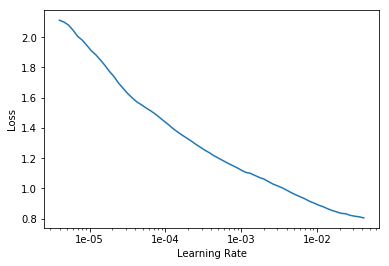

In [56]:
learn.lr_find(start_lr=1e-6, end_lr=1.0, num_it=100, stop_div=True)
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10, max_lr=1e-3, callbacks=[SaveModelCallback(learn, every='improvement', mode='min',
                                                                  monitor='group_mean_log_mae',  name='mpnn1')])

epoch,train_loss,valid_loss,rmse,mae,group_mean_log_mae,time
0,0.065678,0.059328,0.027907,0.019128,-0.373528,12:53
1,0.055478,0.047966,0.022460,0.015055,-0.716924,12:45
2,0.045403,0.048092,0.022911,0.014820,-0.802774,12:13
3,0.036997,0.034989,0.016427,0.010793,-0.972827,11:56
4,0.031293,0.029891,0.014038,0.009233,-1.231052,11:44
5,0.026620,0.026594,0.012524,0.008690,-1.297033,11:44
6,0.022169,0.022616,0.010584,0.006869,-1.537904,11:42
7,0.018376,0.019812,0.009243,0.005850,-1.725241,11:46
8,0.016237,0.018353,0.008536,0.005345,-1.829478,11:45


Better model found at epoch 0 with group_mean_log_mae value: -0.373527854681015.
Better model found at epoch 1 with group_mean_log_mae value: -0.7169235348701477.
Better model found at epoch 2 with group_mean_log_mae value: -0.80277419090271.
Better model found at epoch 3 with group_mean_log_mae value: -0.9728274941444397.
Better model found at epoch 4 with group_mean_log_mae value: -1.2310518026351929.
Better model found at epoch 5 with group_mean_log_mae value: -1.2970329523086548.
Better model found at epoch 6 with group_mean_log_mae value: -1.5379042625427246.
Better model found at epoch 7 with group_mean_log_mae value: -1.7252414226531982.
Better model found at epoch 8 with group_mean_log_mae value: -1.8294782638549805.


In [ ]:
learn.recorder.plot_losses(skip_start=150)

In [ ]:
learn.fit_one_cycle(20, max_lr=3e-4, callbacks=[SaveModelCallback(learn, every='improvement', mode='min',
                                                                  monitor='group_mean_log_mae',  name='mpnn2')])

In [ ]:
learn.recorder.plot_losses(200)

In [ ]:
learn.fit_one_cycle(20, max_lr=1e-4, callbacks=[SaveModelCallback(learn, every='improvement', mode='min',
                                                                  monitor='group_mean_log_mae',  name='mpnn3')])

In [ ]:
learn.recorder.plot_losses(500)